load libraries

In [97]:
import neurokit2 as nk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from pathlib import Path
from os.path import join
import itertools

plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

#### load data

In [179]:
# %% Get data
pwd = os. getcwd()
main_dir = Path(pwd).parents[1]

# %%
# sub-0053
# ses-03

sub_num = 51
ses_num = 3
run_num = 4
sub = f"sub-{sub_num:04d}"
ses = f"ses-{ses_num:02d}"
run = f"run-{run_num-1:02d}"
physio_fname = join(main_dir, 'data', sub, ses, 'physio', f"SOCIAL_spacetop_{sub}_{ses}_task-social_ANISO.acq")
beh_fname = glob.glob(join(main_dir, 'data', sub, ses, 'beh', f"{sub}_{ses}_task-social_{run}-*_beh.csv"))[0]


#### check data

In [181]:
print("load physio data...")
physio_df, spacetop_samplingrate = nk.read_acqknowledge(physio_fname)
print("check physio data columns: ",physio_df.columns)
# %% Define parameters  
beh_df = pd.read_csv(beh_fname)

load physio data...
check physio data columns:  Index(['Skin Conductance (EDA) - EDA100C-MRI', 'Pulse (PPG) - PPG100C',
       'fMRI Trigger - CBLCFMA - Current Feedba',
       'TSA2 TTL - CBLCFMA - Current Feedback M', 'trigger', 'fixation', 'cue',
       'expect', 'administer', 'actual', 'C15', 'C16'],
      dtype='object')


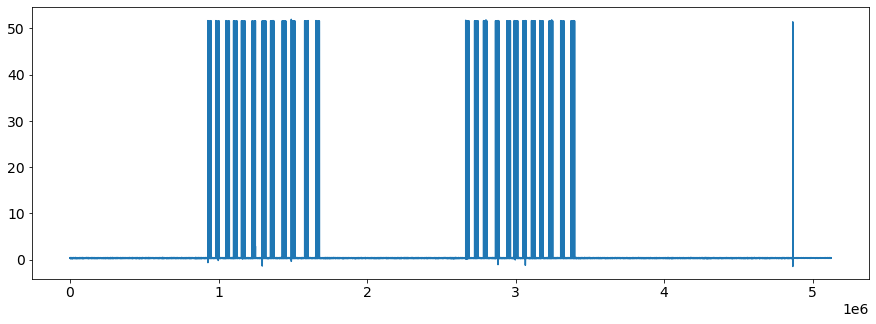

In [182]:
plt.plot(physio_df['TSA2 TTL - CBLCFMA - Current Feedback M'])

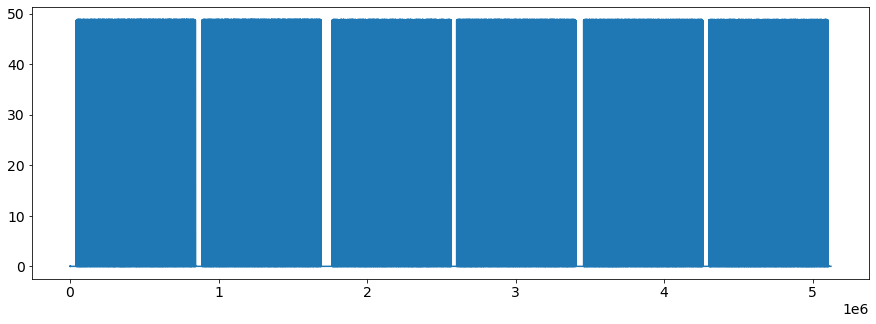

In [183]:
plt.plot(physio_df['fMRI Trigger - CBLCFMA - Current Feedba'])

#### TODO: Later change columns names so that they match figurer

In [ ]:
# physio_df.columns = physio_df.columns.str.replace('old_char', 'new_char')

#### down sample data?

In [ ]:
# %% Downsample data
# spacetop_downsample = nk.signal_resample(physio_df, sampling_rate=2000, desired_sampling_rate=1000, method="interpolation")
## losing signal, further analyses don't work, instead: Heejung approach by dividing (see GitHub)


## preprocess biopac digital channels

#### extract run, based on the trigger column

In [197]:

mid_val = (np.max(physio_df['trigger']) - np.min(physio_df['trigger']))/2
physio_df.loc[physio_df['trigger'] > mid_val, 'fmri_trigger'] = 5
physio_df.loc[physio_df['trigger'] <= mid_val, 'fmri_trigger'] = 0

start_df = physio_df[physio_df['fmri_trigger'] > physio_df['fmri_trigger'].shift(1)].index
stop_df = physio_df[physio_df['fmri_trigger'] < physio_df['fmri_trigger'].shift(1)].index
print(f"* indices of each run's start point 'start_df': \n\t{start_df}")
print(f"* indices of each run's end point: 'stop_df': \n\t{stop_df}")


# %% Organize data: transition
df_transition = pd.DataFrame({
                        'start_df': start_df, 
                        'stop_df': stop_df
                        })
run_subset = physio_df[df_transition.start_df[run_num-1]: df_transition.stop_df[run_num-1]]
run_df = run_subset.reset_index()
print("\n* extract dataframe based on run number")
run_df.head()


* indices of each run's start point 'start_df': 
	Int64Index([43850, 890568, 1765932, 2603584, 3458812, 4302610], dtype='int64')
* indices of each run's end point: 'stop_df': 
	Int64Index([841528, 1688195, 2563573, 3401638, 4256488, 5100278], dtype='int64')

* extract dataframe based on run number


,index,Skin Conductance (EDA) - EDA100C-MRI,Pulse (PPG) - PPG100C,fMRI Trigger - CBLCFMA - Current Feedba,TSA2 TTL - CBLCFMA - Current Feedback M,trigger,fixation,cue,expect,administer,actual,C15,C16,fmri_trigger
0,2603584,6.578063,-0.018616,0.012207,0.335693,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,2603585,6.576537,-0.018005,0.003052,0.305176,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2603586,6.578063,-0.018311,0.006104,0.329590,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,2603587,6.578063,-0.018921,0.003052,0.320435,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,2603588,6.578063,-0.018616,0.009155,0.323486,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


#### `bio_process` on run_df

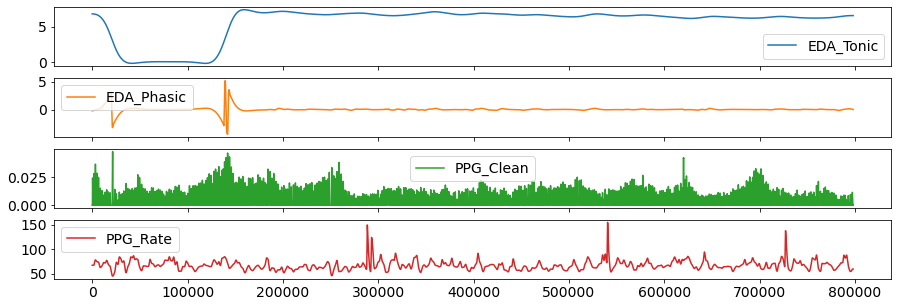

In [198]:

run_df_clean, info = nk.bio_process(eda=run_df["Skin Conductance (EDA) - EDA100C-MRI"], 
                                    ppg=run_df["Pulse (PPG) - PPG100C"],
                                    sampling_rate = spacetop_samplingrate)
plot_clean_signal = run_df_clean[["EDA_Tonic", "EDA_Phasic", "PPG_Clean", "PPG_Rate"]].plot(subplots=True)


#### extract events based on 1) cue

In [199]:
# np.unique(run_04[ 'TSA2 TTL - CBLCFMA - Current Feedback M'])
mid_val = (np.max(run_df['cue']) - np.min(run_df['cue']))/2
run_df.loc[run_df['cue'] > mid_val, 'cue'] = 5
run_df.loc[run_df['cue'] <= mid_val, 'cue'] = 0

start_cue = run_df[run_df['cue'] > run_df[ 'cue'].shift(1)]
stop_cue = run_df[run_df['cue'] < run_df[ 'cue'].shift(1)]
#print(start_stim.index)
#print(stop_stim.index)
print(f"* indices of cue events' start point 'start_cue': \n\t{start_cue.index}")
print(f"* indices of cue events' end point: 'stop_cue': \n\t{stop_cue.index}")

cue_freq = len(start_cue)
print(f"* total number of trials: {cue_freq}")

* indices of cue events' start point 'start_cue': 
	Int64Index([ 22023, 103009, 165999, 234391, 300987, 370210, 426396, 488587,
            540805, 608197, 676189, 752187],
           dtype='int64')
* indices of cue events' end point: 'stop_cue': 
	Int64Index([ 23968, 104967, 167967, 236367, 302967, 372167, 428367, 490567,
            542767, 610167, 678167, 754167],
           dtype='int64')
* total number of trials: 12


#### extract events based on 2) expect_rating

In [200]:
# np.unique(run_04[ 'TSA2 TTL - CBLCFMA - Current Feedback M'])
mid_val = (np.max(run_df['expect']) - np.min(run_df['expect']))/2
run_df.loc[run_df['expect'] > mid_val, 'expect_rating'] = 5
run_df.loc[run_df['expect'] <= mid_val, 'expect_rating'] = 0

start_expectrating = run_df[run_df['expect_rating'] > run_df[ 'expect_rating'].shift(1)]
stop_expectrating = run_df[run_df['expect_rating'] < run_df[ 'expect_rating'].shift(1)]
#print(start_stim.index)
#print(stop_stim.index)
print(f"* indices of expect-rating events' start point 'start_expectrating': \n\t{start_expectrating.index}")
print(f"* indices of expect-rating events' end point: 'stop_expectrating': \n\t{stop_expectrating.index}")

expectrating_freq = len(start_expectrating)
print(f"* total number of trials: {expectrating_freq}")

* indices of expect-rating events' start point 'start_expectrating': 
	Int64Index([ 28653, 107409, 171599, 238618, 305416, 374208, 432997, 494587,
            544805, 612597, 680589, 757786],
           dtype='int64')
* indices of expect-rating events' end point: 'stop_expectrating': 
	Int64Index([ 32694, 112819, 173601, 240559, 307786, 375953, 435565, 498455,
            549252, 614965, 684091, 760419],
           dtype='int64')
* total number of trials: 12


#### extract events based on 3) stimulus intensity

In [201]:
# np.unique(run_04[ 'TSA2 TTL - CBLCFMA - Current Feedback M'])
mid_val = (np.max(run_df['administer']) - np.min(run_df['administer']))/2
run_df.loc[run_df['administer'] > mid_val, 'stimuli'] = 5
run_df.loc[run_df['administer'] <= mid_val, 'stimuli'] = 0

start_stim = run_df[run_df['stimuli'] > run_df[ 'stimuli'].shift(1)]
stop_stim = run_df[run_df['stimuli'] < run_df[ 'stimuli'].shift(1)]
#print(start_stim.index)
#print(stop_stim.index)
print(f"* indices of stimulus events' start point 'start_stim': \n\t{start_stim.index}")
print(f"* indices of stimulus events' end point: 'stop_stim': \n\t{stop_stim.index}")

run_df[run_df[ 'stimuli'].diff() != 0].index
stim_freq = len(start_stim)
print(f"* total number of trials: {stim_freq}")

* indices of stimulus events' start point 'start_stim': 
	Int64Index([ 61048, 120871, 181060, 261673, 337862, 387252, 446044, 504063,
            559438, 623294, 700516, 770835],
           dtype='int64')
* indices of stimulus events' end point: 'stop_stim': 
	Int64Index([ 78968, 138767, 198967, 279567, 355767, 405167, 463967, 521967,
            577367, 641167, 718367, 788767],
           dtype='int64')
* total number of trials: 12


#### extract events based on 4) actual_rating

In [202]:
# np.unique(run_04[ 'TSA2 TTL - CBLCFMA - Current Feedback M'])
mid_val = (np.max(run_df['actual']) - np.min(run_df['actual']))/2
run_df.loc[run_df['actual'] > mid_val, 'actual_rating'] = 5
run_df.loc[run_df['actual'] <= mid_val, 'actual_rating'] = 0

start_actualrating = run_df[run_df['actual_rating'] > run_df[ 'actual_rating'].shift(1)]
stop_actualrating = run_df[run_df['actual_rating'] < run_df[ 'actual_rating'].shift(1)]
#print(start_stim.index)
#print(stop_stim.index)
print(f"* indices of actual-rating events' start point 'start_actualrating': \n\t{start_actualrating.index}")
print(f"* indices of actual-rating events' end point: 'stop_actualrating': \n\t{stop_actualrating.index}")

actualrating_freq = len(start_actualrating)
print(f"* total number of trials: {actualrating_freq}")

* indices of actual-rating events' start point 'start_actualrating': 
	Int64Index([ 90619, 150391, 200810, 291211, 359202, 408588, 476213, 525998,
            597191, 659615, 727807, 789997],
           dtype='int64')
* indices of actual-rating events' end point: 'stop_actualrating': 
	Int64Index([ 95585, 153826, 204019, 294653, 362038, 411189, 480719, 529700,
            603628, 661986, 731686, 794232],
           dtype='int64')
* total number of trials: 12


#### extract TTLs :: identify ttl events based on TTL column

In [203]:
df_stim

,stim_start,stim_end
0,48365,62365
1,102164,116163
2,155364,169363
3,221764,235763
4,293964,307963
5,363564,377563
6,420165,434163
7,492564,506563
8,548364,562363
9,615964,629963


##### build pandas for extracting TTLS 

In [204]:
# build pandas dataframe _________________
df_onset = pd.DataFrame({
    'expect_start': start_expectrating.index, 
    'actual_end': stop_actualrating.index,
    'stim_start': np.nan,
    'stim_end':np.nan
})

df_stim = pd.DataFrame({
    'stim_start': start_stim.index, 
    'stim_end': stop_stim.index
    })

final_df = pd.DataFrame()

In [205]:
mid_val = (np.max(run_df['TSA2 TTL - CBLCFMA - Current Feedback M']) - np.min(run_df['TSA2 TTL - CBLCFMA - Current Feedback M']))/2
run_df.loc[run_df['TSA2 TTL - CBLCFMA - Current Feedback M'] > mid_val, 'TTL'] = 5
run_df.loc[run_df['TSA2 TTL - CBLCFMA - Current Feedback M'] <= mid_val, 'TTL'] = 0

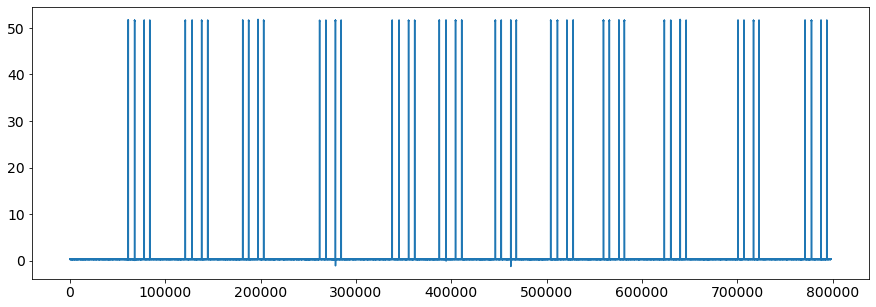

In [206]:
plt.plot(run_df['TSA2 TTL - CBLCFMA - Current Feedback M'])

In [207]:
# calculate TTL onsets
start_ttl = run_df[run_df['TTL'] > run_df[ 'TTL'].shift(1)]
stop_ttl = run_df[run_df['TTL'] < run_df[ 'TTL'].shift(1)]
ttl_onsets =   list(start_ttl.index + (stop_ttl.index-start_ttl.index)/2)
print(f"ttl onsets: {ttl_onsets}, length of ttl onset is : {len(ttl_onsets)}")


ttl onsets: [61106.5, 67775.0, 77778.0, 83712.0, 120929.5, 128047.5, 138048.0, 144425.0, 181121.5, 187340.5, 197342.5, 203119.0, 261745.5, 268363.5, 278364.0, 284372.5, 337908.5, 345097.0, 355097.5, 361494.5, 387310.5, 394359.0, 404359.5, 410837.5, 446103.5, 452261.5, 462261.5, 468071.0, 504135.5, 511204.0, 521204.5, 527668.5, 559508.0, 565669.0, 575666.5, 581432.5, 623360.5, 630049.5, 640049.5, 646158.0, 700584.5, 706882.5, 716883.0, 722641.5, 770907.5, 777655.5, 787658.5, 793774.5], length of ttl onset is : 48


In [208]:
df_onset['expect_start']

0      28653
1     107409
2     171599
3     238618
4     305416
5     374208
6     432997
7     494587
8     544805
9     612597
10    680589
11    757786
Name: expect_start, dtype: int64

In [209]:
for i in range(len(df_stim)):
    idx = pd.IntervalIndex.from_arrays(
        df_onset['expect_start'], df_onset['actual_end'])
    start_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_start')]
    interval_idx = df_onset[idx.contains(start_val)].index[0]
    df_onset.iloc[interval_idx, df_onset.columns.get_loc('stim_start')] = start_val

    end_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_end')]
    interval_idx = df_onset[idx.contains(end_val)].index[0]
    df_onset.iloc[interval_idx, df_onset.columns.get_loc('stim_end')] = end_val
    print(f"this is the {i}-th iteration. stim value is {start_val}, and is in between index {interval_idx}")

# identify events :: TTL _________________
# calculate TTL onsets
start_ttl = run_df[run_df['TTL'] > run_df[ 'TTL'].shift(1)]
stop_ttl = run_df[run_df['TTL'] < run_df[ 'TTL'].shift(1)]
ttl_onsets =   list(start_ttl.index + (stop_ttl.index-start_ttl.index)/2)
print(f"ttl onsets: {ttl_onsets}, length of ttl onset is : {len(ttl_onsets)}")

# define empty TTL data frame
df_ttl = pd.DataFrame(np.nan, 
                    index=np.arange(len(df_onset)),
                    columns= ['ttl_1', 'ttl_2','ttl_3', 'ttl_4'])

# identify which set of TTLs fall between expect and actual 
pad = 1 # seconds. you may increase the value to have a bigger event search interval
df_onset['expect_start_interval'] = df_onset['expect_start']-pad
df_onset['actual_end_interval'] = df_onset['actual_end']+pad
idx = pd.IntervalIndex.from_arrays(
            df_onset['expect_start_interval'], df_onset['actual_end_interval'])

for i in range(len(ttl_onsets)):
    
    val = ttl_onsets[i]
    print(f"{i}-th value: {val}")
    empty_cols = []
    interval_idx = df_onset[idx.contains(val)].index[0]
    print(f"\t\t* interval index: {interval_idx}")
    mask = df_ttl.loc[[interval_idx]].isnull()
    empty_cols = list(itertools.compress(np.array(df_ttl.columns.to_list()), mask.values[0]))
    print(f"\t\t* empty columns: {empty_cols}")
    df_ttl.loc[df_ttl.index[interval_idx], str(empty_cols[0])] = val
    print(f"\t\t* this is the row where the value -- {val} -- falls. on the {interval_idx}-th row")


# merge :: merge df_onset and df_ttl -> final output: final_df
final_df = pd.merge(df_onset, df_ttl, left_index=True, right_index=True)
final_df['ttl_r1'] = final_df['ttl_1'] - final_df['stim_start']
final_df['ttl_r2'] = final_df['ttl_2'] - final_df['stim_start']
final_df['ttl_r3'] = final_df['ttl_3'] - final_df['stim_start']
final_df['ttl_r4'] = final_df['ttl_4'] - final_df['stim_start']

this is the 0-th iteration. stim value is 61048, and is in between index 0
this is the 1-th iteration. stim value is 120871, and is in between index 1
this is the 2-th iteration. stim value is 181060, and is in between index 2
this is the 3-th iteration. stim value is 261673, and is in between index 3
this is the 4-th iteration. stim value is 337862, and is in between index 4
this is the 5-th iteration. stim value is 387252, and is in between index 5
this is the 6-th iteration. stim value is 446044, and is in between index 6
this is the 7-th iteration. stim value is 504063, and is in between index 7
this is the 8-th iteration. stim value is 559438, and is in between index 8
this is the 9-th iteration. stim value is 623294, and is in between index 9
this is the 10-th iteration. stim value is 700516, and is in between index 10
this is the 11-th iteration. stim value is 770835, and is in between index 11
ttl onsets: [61106.5, 67775.0, 77778.0, 83712.0, 120929.5, 128047.5, 138048.0, 144425

In [210]:
final_df

,expect_start,actual_end,stim_start,stim_end,expect_start_interval,actual_end_interval,ttl_1,ttl_2,ttl_3,ttl_4,ttl_r1,ttl_r2,ttl_r3,ttl_r4
0,28653,95585,61048.0,78968.0,28652,95586,61106.5,67775.0,77778.0,83712.0,58.5,6727.0,16730.0,22664.0
1,107409,153826,120871.0,138767.0,107408,153827,120929.5,128047.5,138048.0,144425.0,58.5,7176.5,17177.0,23554.0
2,171599,204019,181060.0,198967.0,171598,204020,181121.5,187340.5,197342.5,203119.0,61.5,6280.5,16282.5,22059.0
3,238618,294653,261673.0,279567.0,238617,294654,261745.5,268363.5,278364.0,284372.5,72.5,6690.5,16691.0,22699.5
4,305416,362038,337862.0,355767.0,305415,362039,337908.5,345097.0,355097.5,361494.5,46.5,7235.0,17235.5,23632.5
5,374208,411189,387252.0,405167.0,374207,411190,387310.5,394359.0,404359.5,410837.5,58.5,7107.0,17107.5,23585.5
6,432997,480719,446044.0,463967.0,432996,480720,446103.5,452261.5,462261.5,468071.0,59.5,6217.5,16217.5,22027.0
7,494587,529700,504063.0,521967.0,494586,529701,504135.5,511204.0,521204.5,527668.5,72.5,7141.0,17141.5,23605.5
8,544805,603628,559438.0,577367.0,544804,603629,559508.0,565669.0,575666.5,581432.5,70.0,6231.0,16228.5,21994.5
9,612597,661986,623294.0,641167.0,612596,661987,623360.5,630049.5,640049.5,646158.0,66.5,6755.5,16755.5,22864.0


In [23]:
beh_df['cond_name'] = beh_df['param_cue_type'].astype(str) + '_' + beh_df['param_stimulus_type'].astype(str)

In [223]:
beh_df['param_stimulus_type'].values.tolist()

['med_stim',
 'low_stim',
 'med_stim',
 'high_stim',
 'high_stim',
 'high_stim',
 'med_stim',
 'low_stim',
 'high_stim',
 'low_stim',
 'low_stim',
 'med_stim']

## Manage events

#### For simplicity, let's see if physio response differs as a function of stimulus intensity.

In [224]:
# build direction
event_stim = {'onset':np.array(start_stim.index),
'duration':np.repeat(spacetop_samplingrate*5, 12),
'label':np.array(np.arange(12)),
'condition':beh_df['param_stimulus_type'].values.tolist()}

# {'onset': array([ 1024,  4957,  9224, 12984]),
#  'duration': array([300, 300, 300, 300]),
#  'label': array(['1', '2', '3', '4'], dtype='<U21'),
#  'condition': ['Negative', 'Neutral', 'Neutral', 'Negative']}


In [225]:
run_df.columns

Index(['index', 'Skin Conductance (EDA) - EDA100C-MRI',
       'Pulse (PPG) - PPG100C', 'fMRI Trigger - CBLCFMA - Current Feedba',
       'TSA2 TTL - CBLCFMA - Current Feedback M', 'trigger', 'fixation', 'cue',
       'expect', 'administer', 'actual', 'C15', 'C16', 'fmri_trigger',
       'expect_rating', 'stimuli', 'actual_rating', 'TTL'],
      dtype='object')

#### plot events

In [226]:
run_physio = run_df[['Skin Conductance (EDA) - EDA100C-MRI',
'Pulse (PPG) - PPG100C',
'TTL']]

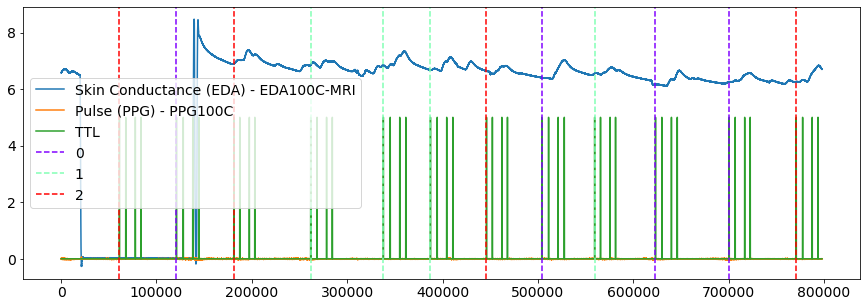

In [227]:
plot = nk.events_plot(event_stim, run_physio)

## Manage events V2 :: based on Plateau TTL

In [230]:
# build direction
ttl2 = final_df['ttl_2'].values.tolist()
plateau_start = np.ceil(ttl2).astype(int)
event_plateau = {'onset':np.array(plateau_start),
'duration':np.repeat(spacetop_samplingrate*5, 12),
'label':np.array(np.arange(12)),
'condition':beh_df['param_stimulus_type'].values.tolist()}


## Manage epochs V2 (segments of events) based on TTL

In [231]:
epochs_plateau = nk.epochs_create(run_physio, 
                                event_plateau, 
                                sampling_rate=2000, 
                                epochs_start=-1, 
                                epochs_end=6,
                                baseline_correction=True) 

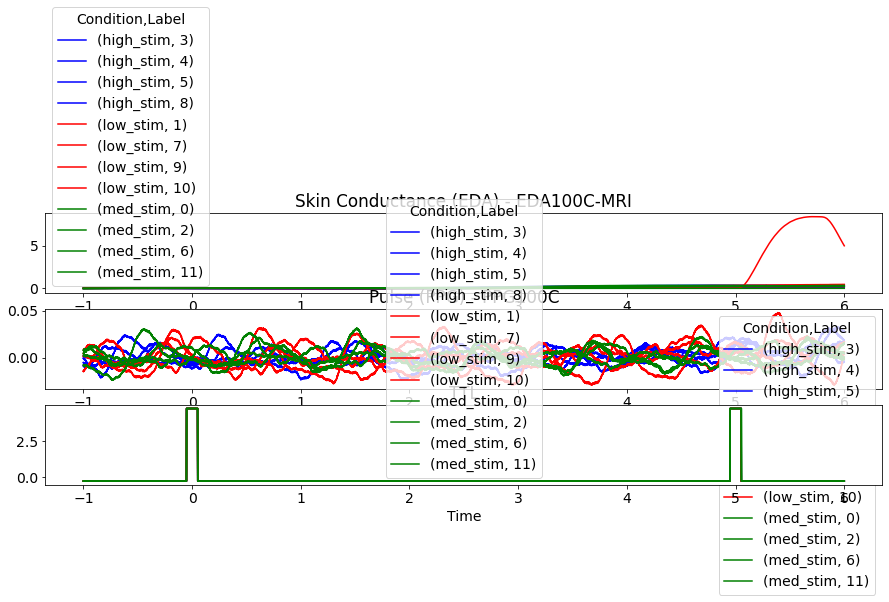

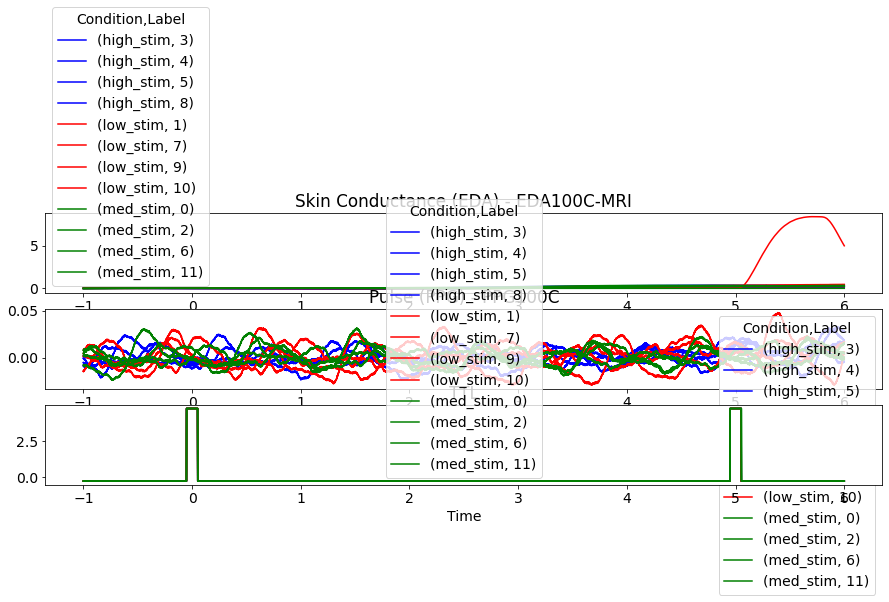

In [232]:
# original data
nk.epochs_plot(epochs_plateau)

CAN WE NOW USE RUN_DF_CLEAN?

In [233]:
epochs_plateau_clean = nk.epochs_create(run_df_clean, 
                                event_plateau, 
                                sampling_rate=2000, 
                                epochs_start=-1, 
                                epochs_end=6,
                                baseline_correction=True) 

In [234]:
event_plateau

{'onset': array([ 67775, 128048, 187341, 268364, 345097, 394359, 452262, 511204,
        565669, 630050, 706883, 777656]),
 'duration': array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000.]),
 'label': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 'condition': ['med_stim',
  'low_stim',
  'med_stim',
  'high_stim',
  'high_stim',
  'high_stim',
  'med_stim',
  'low_stim',
  'high_stim',
  'low_stim',
  'low_stim',
  'med_stim']}

In [235]:
# data snipping out jut plateau
nk.epochs_plot(event_plateau,epochs_plateau_clean)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

## Note to self:

In [ ]:

epochs_stim = nk.epochs_create(run_physio, 
                                event_stim, 
                                sampling_rate=2000, 
                                epochs_start=-1, 
                                epochs_end=11,
                                baseline_correction=True)

#### extract events based on 2) expectation rating

In [ ]:
expect_start = run_df[run_df['expect'] > run_df['expect'].shift(1)]
expect_end = run_df[run_df['expect'] < run_df['expect'].shift(1)]

# %% Extract start & end for creating events
# expect_start_list = expect_start["index"].values.tolist()
expect_start_list = expect_start.index.tolist()
print(expect_start_list)
expect_end_list = expect_end.index.tolist()
event_labels = [1,2,1,3,5,6,5,4,4,6,2,3] # muss man irgendwie in events reinkriegen 

# %% Define events
expect_events = nk.events_create(event_onsets = expect_start_list, 
                                 event_durations = 8000, # brauche ich die Länge überhaupt?
                                 event_conditions = event_labels)
print(expect_events)

plot_expect = nk.events_plot(expect_events, run_df_clean['EDA_Clean'])
plot_eda_expect = nk.events_plot(expect_events, run_df["Skin Conductance (EDA) - EDA100C-MRI"])
plot_ppg_expect = nk.events_plot(expect_events, run_df["Pulse (PPG) - PPG100C"])


# %% Create epochs 
expect_epochs = nk.epochs_create(run_df_clean, 
                                 expect_events, 
                                 sampling_rate = spacetop_samplingrate, 
                                 epochs_start = -1, epochs_end = 8) # kann man auch end_list nehmen? / aktuell zu kurz um intervalrelated zu machen

expect_epochs = nk.epochs_create(run_df_clean, 
                                 expect_events, 
                                 sampling_rate = spacetop_samplingrate, 
                                 epochs_start = 0, epochs_end = 8)

plot_epochs_expect = nk.epochs_plot(expect_epochs)
for epoch in expect_epochs.values():
    nk.signal_plot(epoch[["EDA_Clean", "SCR_Height"]], 
    title = epoch['Condition'].values[0],
    standardize = True)
    
# %% Analyze features 
expect_analysis = nk.bio_analyze(expect_epochs, sampling_rate=spacetop_samplingrate, 
                                method="event-related")

print(expect_analysis)
expect_analysis.to_csv("results_expect.csv")

# %% reshape pandas from 0 - 11 
expect_analysis.reset_index(inplace=True)

#%% 
b_p = pd.merge(expect_analysis, beh_df, left_index=True, right_index = True)
b_p ["sub_id"] = "53"
b_p.to_csv("firstresults_6.csv")

In [ ]:

# Expect trigger 
# %% Start & end of condition 
expect_start = run_df[run_df['expect'] > run_df['expect'].shift(1)]
expect_end = run_df[run_df['expect'] < run_df['expect'].shift(1)]

# %% Extract start & end for creating events
# expect_start_list = expect_start["index"].values.tolist()
expect_start_list = expect_start.index.tolist()
print(expect_start_list)
expect_end_list = expect_end.index.tolist()
event_labels = [1,2,1,3,5,6,5,4,4,6,2,3] # muss man irgendwie in events reinkriegen 

# %% Define events
expect_events = nk.events_create(event_onsets = expect_start_list, 
                                 event_durations = 8000, # brauche ich die Länge überhaupt?
                                 event_conditions = event_labels)
print(expect_events)

plot_expect = nk.events_plot(expect_events, run_df_clean['EDA_Clean'])
plot_eda_expect = nk.events_plot(expect_events, run_df["Skin Conductance (EDA) - EDA100C-MRI"])
plot_ppg_expect = nk.events_plot(expect_events, run_df["Pulse (PPG) - PPG100C"])


# %% Create epochs 
expect_epochs = nk.epochs_create(run_df_clean, 
                                 expect_events, 
                                 sampling_rate = spacetop_samplingrate, 
                                 epochs_start = -1, epochs_end = 8) # kann man auch end_list nehmen? / aktuell zu kurz um intervalrelated zu machen

expect_epochs = nk.epochs_create(run_df_clean, 
                                 expect_events, 
                                 sampling_rate = spacetop_samplingrate, 
                                 epochs_start = 0, epochs_end = 8)

plot_epochs_expect = nk.epochs_plot(expect_epochs)
for epoch in expect_epochs.values():
    nk.signal_plot(epoch[["EDA_Clean", "SCR_Height"]], 
    title = epoch['Condition'].values[0],
    standardize = True)
    
# %% Analyze features 
expect_analysis = nk.bio_analyze(expect_epochs, sampling_rate=spacetop_samplingrate, 
                                method="event-related")

print(expect_analysis)
expect_analysis.to_csv("results_expect.csv")

# %% reshape pandas from 0 - 11 
expect_analysis.reset_index(inplace=True)

#%% 
b_p = pd.merge(expect_analysis, beh_df, left_index=True, right_index = True)
b_p ["sub_id"] = "53"
b_p.to_csv("firstresults_6.csv")

###############################################################################################

# Administer trigger

# %% Start & end of condition 
administer_start = run_df[run_df['administer'] > run_df['administer'].shift(1)] # ist expect da doch passender? oder siehe github
administer_end = run_df[run_df['administer'] < run_df['administer'].shift(1)] 
# also ist das so zu verstehen dass expect die bed ist und man nur irgendwie als event onset den administer einpflegen muss? 

# %% Extract start & end for creating events
administer_start_list = administer_start.index.tolist()
print(administer_start_list)
administer_end_list = administer_end.index.tolist()
administer_event_labels = [1,2,1,3,5,6,5,4,4,6,2,3] # muss man irgendwie in events reinkriegen 

# %% Define events
administer_events = nk.events_create(event_onsets = administer_start_list, 
                                    event_durations = 8000, # brauche ich die Länge überhaupt?
                                    event_conditions = administer_event_labels)
print(administer_events) 

plot_eda_administer = nk.events_plot(administer_events, physio_df["Skin Conductance (EDA) - EDA100C-MRI"])
plot_ppg_administer = nk.events_plot(administer_events, physio_df["Pulse (PPG) - PPG100C"])


# %% Create epochs 
administer_epochs = nk.epochs_create(run_df_clean, 
                                    administer_events, 
                                    sampling_rate = spacetop_samplingrate, 
                                    epochs_start = -1, epochs_end = 10) # kann man auch end_list nehmen? / aktuell zu kurz um intervalrelated zu machen

plot_epochs_administer = nk.epochs_plot(administer_epochs)
for epoch in administer_epochs.values():
    nk.signal_plot(epoch[["EDA_Clean", "SCR_Height"]], 
    title = epoch['Condition'].values[0],
    standardize = True)


# %% Analyze features 
administer_analysis = nk.bio_analyze(administer_epochs, 
                                    sampling_rate=spacetop_samplingrate, 
                                    method = "event-related")

print(administer_analysis)
administer_analysis.to_csv("results_administer.csv")


# %% reshape pandas from 0 - 11 
administer_analysis.reset_index(inplace=True)

#%% 
b_p = pd.merge(administer_analysis, beh_df, left_index=True, right_index = True)
b_p ["sub_id"] = "53"
b_p.to_csv("firstresults_6.csv")

##################################################################################################
# %%
# deeper into ppg: 
# run_df_ppg, info = nk.ppg_process(physio_df["Pulse (PPG) - PPG100C"], 
                                  # sampling_rate = spacetop_samplingrate)

#spacetop_epochs_ppg = nk.epochs_create(run_df_ppg, 
                          #spacetop_events, 
                          #sampling_rate=spacetop_samplingrate, 
                          #epochs_start=-1, epochs_end=8)

#df_ppg = nk.ppg_intervalrelated(run_df_ppg, sampling_rate = spacetop_samplingrate)

#for epoch in spacetop_epochs.values():
    # Plot scaled signals
    #nk.signal_plot(epoch[['Skin Conductance (EDA) - EDA100C-MRI', 'Pulse (PPG) - PPG100C',"expect"]], 
                   #title=epoch['Condition'].values[0],  # Extract condition name
                   #standardize=True) 


# spacetop_events = nk.events_find(event_channel = run_df['expect'],
                                 #start_at = start_list, 
                                 #end_at = end_list,
                                # event_labels = event_labels)


# irgendwie durch liste durchiterieren?

#plot = nk.events_plot(events_spacetop)
                                     
                                     #events = {"onset": []}
#if start_at>0: 
    #events_spacetop["onset"] = events_spacetop["onset"][events_spacetop["onset"] >= start_at]
    
#if end_at is not None
    #events_spacetop["onset"] = events_spacetop["onset"][events_spacetop["onset"] <= end_at]

                                 #event_labels = event_labels) 

# mit heejung
#events_spacetop = nk.events_find(event_channel = run_df['expect'],
                                 #start_at = expect_start['expect'], 
                                 #end_at = expect_end['expect'])
                                 
 #duration_min = 7900,
 #duration_max = 8100, 

# plot = nk.events_plot(events, physio_df['expect'])






# %%